In [1]:
import sys
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path

## § 15.5.	Exercises

9) Train a classification model for the SketchRNN dataset, available in TensorFlow Datasets.

In [2]:
tf_download_root = "http://download.tensorflow.org/data/"
filename = "quickdraw_tutorial_dataset_v1.tar.gz"
filepath = tf.keras.utils.get_file(filename,
                                   tf_download_root + filename,
                                   cache_dir=".",
                                   extract=True)

1065301781/1065301781 [==============================] - 51s 0us/step


In [3]:
quickdraw_dir = Path(filepath).parent
train_files = sorted(
    [str(path) for path in quickdraw_dir.glob("training.tfrecord-*")]
)
eval_files = sorted(
    [str(path) for path in quickdraw_dir.glob("eval.tfrecord-*")]
)

In [4]:
train_files

['datasets/training.tfrecord-00000-of-00010',
 'datasets/training.tfrecord-00001-of-00010',
 'datasets/training.tfrecord-00002-of-00010',
 'datasets/training.tfrecord-00003-of-00010',
 'datasets/training.tfrecord-00004-of-00010',
 'datasets/training.tfrecord-00005-of-00010',
 'datasets/training.tfrecord-00006-of-00010',
 'datasets/training.tfrecord-00007-of-00010',
 'datasets/training.tfrecord-00008-of-00010',
 'datasets/training.tfrecord-00009-of-00010']

In [5]:
eval_files

['datasets/eval.tfrecord-00000-of-00010',
 'datasets/eval.tfrecord-00001-of-00010',
 'datasets/eval.tfrecord-00002-of-00010',
 'datasets/eval.tfrecord-00003-of-00010',
 'datasets/eval.tfrecord-00004-of-00010',
 'datasets/eval.tfrecord-00005-of-00010',
 'datasets/eval.tfrecord-00006-of-00010',
 'datasets/eval.tfrecord-00007-of-00010',
 'datasets/eval.tfrecord-00008-of-00010',
 'datasets/eval.tfrecord-00009-of-00010']

In [6]:
with open(quickdraw_dir / "eval.tfrecord.classes") as test_classes_file:
  test_classes = test_classes_file.readlines()

with open(quickdraw_dir / "training.tfrecord.classes") as train_classes_file:
  train_classes = train_classes_file.readlines()

In [7]:
assert train_classes == test_classes
class_names = [name.strip().lower() for name in train_classes]

In [8]:
sorted(class_names)

['aircraft carrier',
 'airplane',
 'alarm clock',
 'ambulance',
 'angel',
 'animal migration',
 'ant',
 'anvil',
 'apple',
 'arm',
 'asparagus',
 'axe',
 'backpack',
 'banana',
 'bandage',
 'barn',
 'baseball',
 'baseball bat',
 'basket',
 'basketball',
 'bat',
 'bathtub',
 'beach',
 'bear',
 'beard',
 'bed',
 'bee',
 'belt',
 'bench',
 'bicycle',
 'binoculars',
 'bird',
 'birthday cake',
 'blackberry',
 'blueberry',
 'book',
 'boomerang',
 'bottlecap',
 'bowtie',
 'bracelet',
 'brain',
 'bread',
 'bridge',
 'broccoli',
 'broom',
 'bucket',
 'bulldozer',
 'bus',
 'bush',
 'butterfly',
 'cactus',
 'cake',
 'calculator',
 'calendar',
 'camel',
 'camera',
 'camouflage',
 'campfire',
 'candle',
 'cannon',
 'canoe',
 'car',
 'carrot',
 'castle',
 'cat',
 'ceiling fan',
 'cell phone',
 'cello',
 'chair',
 'chandelier',
 'church',
 'circle',
 'clarinet',
 'clock',
 'cloud',
 'coffee cup',
 'compass',
 'computer',
 'cookie',
 'cooler',
 'couch',
 'cow',
 'crab',
 'crayon',
 'crocodile',
 'crow

In [9]:
def parse(data_batch):
  feature_descriptions = {
      "ink": tf.io.VarLenFeature(dtype=tf.float32),
      "shape": tf.io.FixedLenFeature([2], dtype=tf.int64),
      "class_index": tf.io.FixedLenFeature([1], dtype=tf.int64)
  }
  examples = tf.io.parse_example(data_batch, feature_descriptions)
  flat_sketches = tf.sparse.to_dense(examples["ink"])
  sketches = tf.reshape(flat_sketches, shape=[tf.size(data_batch), -1, 3])
  lengths = examples["shape"][:, 0]
  labels = examples["class_index"][:, 0]
  return sketches, lengths, labels

In [10]:
def quickdraw_dataset(filepaths, batch_size=32, shuffle_buffer_size=None,
                      n_parse_threads=5, n_read_threads=5, cache=False):
  dataset = tf.data.TFRecordDataset(filepaths,
                                    num_parallel_reads=n_read_threads)
  if cache:
    dataset = dataset.cache()
  if shuffle_buffer_size:
    dataset = dataset.shuffle(shuffle_buffer_size)
  dataset = dataset.batch(batch_size)
  dataset = dataset.map(parse, num_parallel_calls=n_parse_threads)
  return dataset.prefetch(1)

In [11]:
train_set = quickdraw_dataset(train_files, shuffle_buffer_size=10000)
valid_set = quickdraw_dataset(eval_files[:5])
test_set = quickdraw_dataset(eval_files[5:])

In [12]:
for sketches, lengths, labels in train_set.take(1):
  print("sketches =", sketches)
  print("lengths =", lengths)
  print("labels =", labels)

sketches = tf.Tensor(
[[[ 0.15686275  0.01363636  0.        ]
  [ 0.4117647  -0.03181818  0.        ]
  [ 0.03529412  0.01363636  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.          0.09356725  0.        ]
  [ 0.02745098  0.16374266  0.        ]
  [ 0.          0.3450293   0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[-0.0147059   0.19215685  0.        ]
  [ 0.02941176  0.03137255  0.        ]
  [ 0.05882353  0.02745098  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 ...

 [[-0.1456693   0.06435643  0.        ]
  [-0.13385826  0.15346535  0.        ]
  [-0.03937008  0.15841582  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.    

In [14]:
import numpy as np

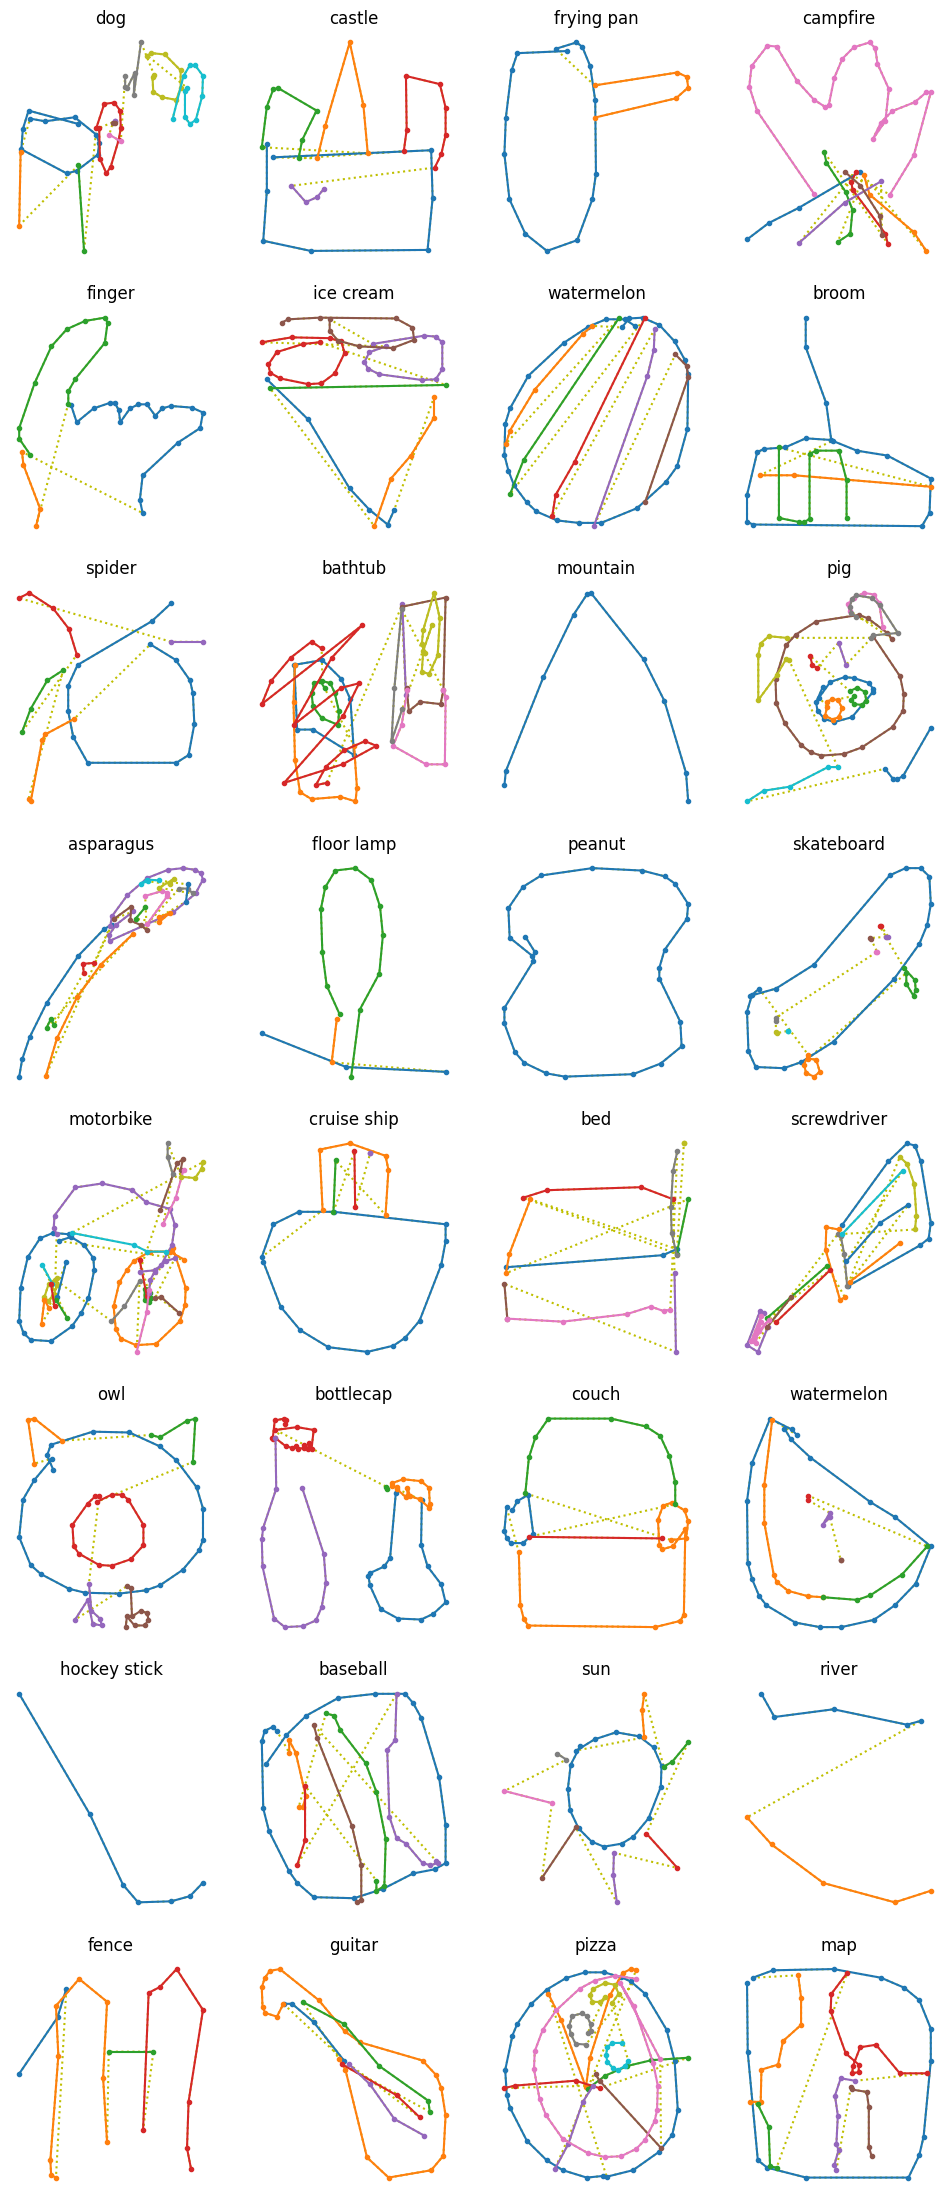

In [15]:
def draw_sketch(sketch, label=None):
  origin = np.array([[0., 0., 0.]])
  sketch = np.r_[origin, sketch]
  stroke_end_indices = np.argwhere(sketch[:, -1]==1.)[:, 0]
  coordinates = sketch[:, :2].cumsum(axis=0)
  strokes = np.split(coordinates, stroke_end_indices + 1)
  title = class_names[label.numpy()] if label is not None else "Try to guess"
  plt.title(title)
  plt.plot(coordinates[:, 0], -coordinates[:, 1], "y:")
  for stroke in strokes:
    plt.plot(stroke[:, 0], -stroke[:, 1], ".-")
  plt.axis("off")

def draw_sketches(sketches, lengths, labels):
  n_sketches = len(sketches)
  n_cols = 4
  n_rows = (n_sketches - 1) // n_cols + 1
  plt.figure(figsize=(n_cols * 3, n_rows * 3.5))
  for index, sketch, length, label in zip(range(n_sketches), sketches, lengths, labels):
    plt.subplot(n_rows, n_cols, index + 1)
    draw_sketch(sketch[:length], label)
  plt.show()

for sketches, lengths, labels in train_set.take(1):
  draw_sketches(sketches, lengths, labels)

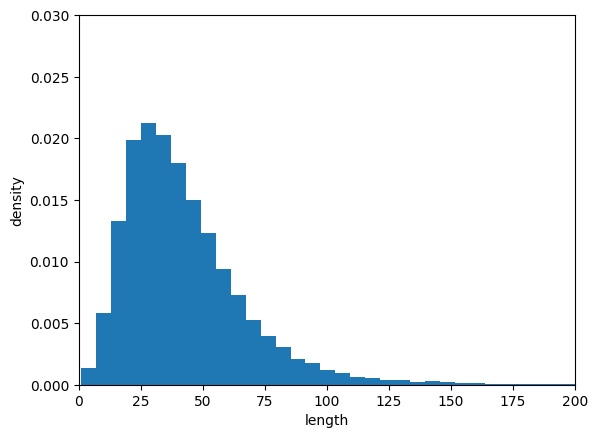

In [16]:
lengths = np.concatenate([lengths for _, lengths, _ in train_set.take(1000)])
plt.hist(lengths, bins=150, density=True)
plt.axis([0, 200, 0, 0.03])
plt.xlabel("length")
plt.ylabel("density")
plt.show()

In [17]:
def crop_long_sketches(dataset, max_length=100):
  return dataset.map(lambda inks, lengths, labels: (inks[:, :max_length], labels))

cropped_train_set = crop_long_sketches(train_set)
cropped_valid_set = crop_long_sketches(valid_set)
cropped_test_set = crop_long_sketches(test_set)

In [18]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(32, kernel_size=5, strides=2, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(64, kernel_size=5, strides=2, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(128, kernel_size=3, strides=2, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(len(class_names), activation="softmax")
])
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2, clipnorm=1.)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy", "sparse_top_k_categorical_accuracy"])
history = model.fit(cropped_train_set,
                    epochs=2,
                    validation_data=cropped_valid_set)

Epoch 1/2
107813/107813 [==============================] - 1351s 12ms/step - loss: 4.0802 - accuracy: 0.1682 - sparse_top_k_categorical_accuracy: 0.3735 - val_loss: 3.0978 - val_accuracy: 0.3054 - val_sparse_top_k_categorical_accuracy: 0.5900
Epoch 2/2
107813/107813 [==============================] - 1416s 13ms/step - loss: 2.7104 - accuracy: 0.3783 - sparse_top_k_categorical_accuracy: 0.6678 - val_loss: 2.5450 - val_accuracy: 0.4103 - val_sparse_top_k_categorical_accuracy: 0.6993


In [19]:
y_test = np.concatenate([labels for _, _, labels in test_set])
y_probas = model.predict(test_set)

5392/5392 [==============================] - 36s 7ms/step


In [20]:
np.mean(tf.keras.metrics.sparse_top_k_categorical_accuracy(y_test, y_probas))

0.58883196

1/1 [==============================] - 1s 711ms/step


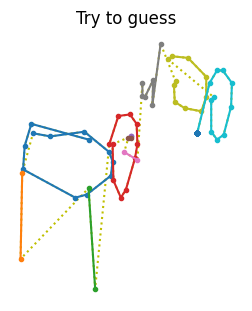

Top-5 predictions:
  1. drums 11.105%
  2. ant 8.946%
  3. sink 8.912%
  4. cannon 8.602%
  5. mosquito 5.031%
Answer: dog


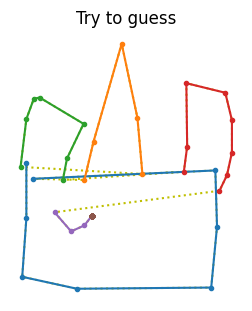

Top-5 predictions:
  1. castle 17.186%
  2. lighter 13.470%
  3. church 8.953%
  4. cruise ship 6.740%
  5. suitcase 4.236%
Answer: castle


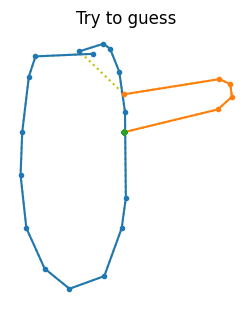

Top-5 predictions:
  1. frying pan 44.223%
  2. spoon 10.530%
  3. nail 5.215%
  4. fork 3.065%
  5. cup 3.015%
Answer: frying pan


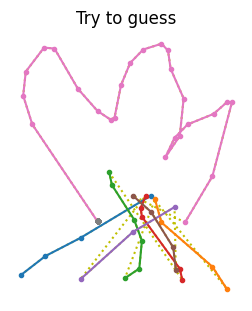

Top-5 predictions:
  1. campfire 64.695%
  2. tree 8.923%
  3. bush 3.782%
  4. fireplace 2.816%
  5. broccoli 2.690%
Answer: campfire


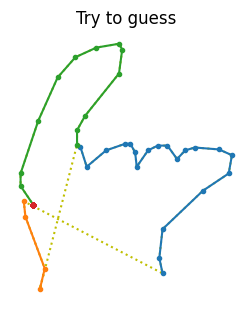

Top-5 predictions:
  1. arm 11.610%
  2. lightning 11.385%
  3. dragon 6.460%
  4. campfire 6.069%
  5. elbow 4.242%
Answer: finger


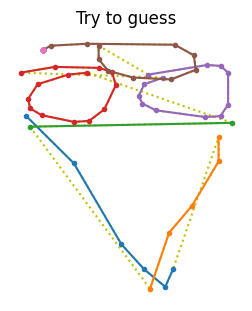

Top-5 predictions:
  1. house plant 28.065%
  2. ice cream 23.235%
  3. traffic light 20.808%
  4. candle 7.380%
  5. floor lamp 2.401%
Answer: ice cream


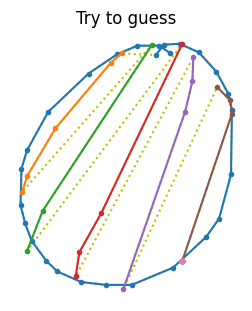

Top-5 predictions:
  1. basketball 30.885%
  2. onion 20.863%
  3. steak 8.556%
  4. harp 7.298%
  5. watermelon 6.786%
Answer: watermelon


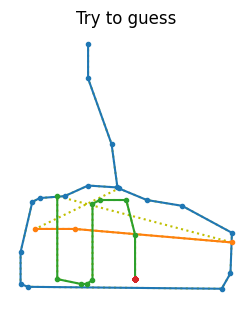

Top-5 predictions:
  1. sword 30.367%
  2. broom 17.352%
  3. syringe 6.322%
  4. chair 4.142%
  5. rake 3.237%
Answer: broom


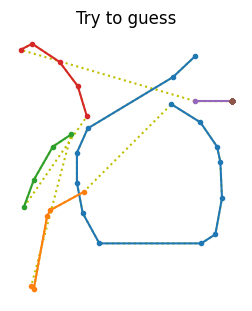

Top-5 predictions:
  1. wristwatch 14.453%
  2. alarm clock 9.596%
  3. sun 7.079%
  4. helicopter 6.462%
  5. stop sign 4.744%
Answer: spider


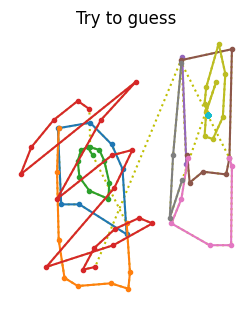

Top-5 predictions:
  1. paintbrush 9.829%
  2. windmill 9.817%
  3. drums 8.152%
  4. camouflage 3.496%
  5. matches 2.740%
Answer: bathtub


In [21]:
n_new = 10
Y_probas = model.predict(sketches)
top_k = tf.nn.top_k(Y_probas, k=5)
for index in range(n_new):
  plt.figure(figsize=(3, 3.5))
  draw_sketch(sketches[index])
  plt.show()
  print("Top-5 predictions:".format(index + 1))
  for k in range(5):
    class_name = class_names[top_k.indices[index, k]]
    proba = 100 * top_k.values[index, k]
    print("  {}. {} {:.3f}%".format(k + 1, class_name, proba))
  print("Answer: {}".format(class_names[labels[index].numpy()]))

In [22]:
model.save("my_sketchrnn", save_format="tf")